# **AI Project: message classification of 20 News Group**

> ### **Comparison between Decision Trees and Neural Networks**
> ###### Luca Minnei (70/90/00339) and Nicola Deidda (70/90/00358)


# **Abstract**

This project aims to compare the performance of two classification techniques: Decision Trees and Neural Networks.

The classification has been done over almost 20 thousand messages, contained in the dataset "20 Newsgroup". These messages are divided into 20 categories, one for each possible topic. For instance, some of these topics are computer graphics, religion, motorcycles, etc.

We aim to train the classifiers and correctly classify our training set of messages using the 5-folds cross-validation techniques.

In the end, we will compare the result, discussing possible issues related to overfitting and to the number of features selected.




# **Case study**

To reach the goal described in the previous section, we followed this chain of steps:
1. Load the dataset and remove headers and footers
2. Remove the stopwords
3. Stemming
4. Apply 5-fold cross-validation
5. Compute feature vector
6. Extract features
7. Train the classifiers
8. Compute and compare the accuracies and misclassification rates








## Load dataset

To perform the steps listed above, it has been decided to use the library ```
sklearn```, which allows us to import the dataset without the headers, footers and quotes. This library made available some other functions that we will use later.

```
sklearn.datasets.fetch_20newsgroups(subset=’train’, categories = None, shuffle = True, random_state=42, remove=(), download_if_missing=True)
```


*   ***subset***: allows us to select either train, test or all. In the following implementation we decide to import separately the train and the test because usually the test set is not randomly chosen, but the samples which belong to this respect some criteria, to improve the generalization capability.
*   ***categories***: the list of categories to fetch. In the first implementation, we fetch all the available categories, in the second we decide to fetch only two categories, to compare this latter implementation with the former, keeping the same algorithm implementation.
*   ***remove***: a tuple containing the parts of the messages to remove. For instance, we remove the headers, footers and quotes, given that they are useless and harmful for the classification.
*   ***shuffle***: shuffle the samples
*   ***random_state***: set the seed to shuffle the samples.


In [ ]:
from sklearn.datasets import fetch_20newsgroups

# import the complete dataset without headers, footers, quotes
train = dict()
test = dict()

# This line is to use only two categories
# categories = ['alt.atheism', 'soc.religion.christian']

# This line is to use all thee categories
categories = None

test["msg"]= fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'),categories=categories, shuffle=True, random_state=42)
train["msg"] = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'),categories=categories, shuffle=True, random_state=42)

# get the labels from train and test
test["lbl"] = test["msg"].target
train["lbl"] = train["msg"].target

## Sanitize messages

This section include the code used to remove stopwords and punctuation and to stem the words in the messages.

We used the libraries: [```nltk```](https://www.nltk.org), to get a list of stopwords and a stemmer, and ```strings``` to get the punctuation characters.



```
sanitize_messages(messages: list) -> list
```
This function gets in input a list of messages and returns a list of sanitized ones.
The messages are stemmed after the removal of punctuation and stopwords.

Looking in depth at how ```sanitize_messages``` works, the stemmer uses the Porter stemming algorithm, which means it removes the commoner morphological and inflexional endings from words in English.

Other functions remove stopwords and punctuation given that these are useless and harmful for classification problems.

At the bottom of the code block we download two additional packets from ```nltk```, which include the stopwords list and the tokenizer (Punkt).



In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

def remove_punctuation(message: str) -> str:
    """Remove punctuation from a message."""
    return "".join([c for c in message if c not in string.punctuation])


def remove_stopwords(message: str, stop_word: set) -> list:
    """Tokenize and remove stopwords from a message."""
    return [word for word in word_tokenize(message.lower()) if word not in stop_word]


def stem_messages(message: list, stemmer: PorterStemmer) -> list:
    """Stem a list of messages."""
    return [stemmer.stem(el) for el in message]


def sanitize_messages(messages: list) -> list:
    """Remove punctuation, tokenize and remove stopwords from a list of messages."""
    stemmer = PorterStemmer()
    stop_word = set(stopwords.words('english'))
    return [stem_messages(remove_stopwords(remove_punctuation(message), stop_word), stemmer) for message in messages]

# download nltk data
if not nltk.download('punkt'):
    nltk.download('punkt')

if not nltk.download('stopwords'):
    nltk.download('stopwords')

# ITEMS 1 AND 2
train["msg"] = sanitize_messages(train["msg"].data)
test["msg"]  = sanitize_messages(test["msg"].data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## K-fold

K-fold, or cross-validation, is a technique which requires dividing the whole set of training samples 𝒟 in k different folds of equal size.

We train our classifier by joining (k-1) folds and using the remaining one to validate the result, to choose the best combination of features number and the type of the classifier.

The training set has been splitted into 5 folds, each one containing almost the same number of random samples. Given the total number of samples in the training set, is not possible to divide it perfectly into five subset: due to that, one of the subfolds contain a few extra samples.


In [ ]:
import numpy as np


def split_n_folds(n_folds: int, messages: list, labels:list, shuffled_idx: list) -> tuple:
    """Split the data into n_folds folds."""
    training_folds_el = []
    training_folds_labels = []
    offest = (len(shuffled_idx)//n_folds)
    for i in range(n_folds):
        training_folds_el.append([messages[j] for j in shuffled_idx[offest*i:offest*(i+1)]])
        training_folds_labels.append([labels[j] for j in shuffled_idx[offest*i:offest*(i+1)]])
        
    return training_folds_el , training_folds_labels

def shuffle_idx(len_labels: int) -> list:
    """Shuffle the index of the elements."""
    idx = np.linspace(0, len_labels, num=len_labels, endpoint=False, dtype='int')
    np.random.shuffle(idx)
    return idx


# ITEMS 3
# Split the data into 5 fold
idx = shuffle_idx(len(train["lbl"]))
training_folds_el, training_folds_labels = split_n_folds(5, train["msg"], train["lbl"], idx)

## Features extraction & Classification

For each fold, we perform a sequence of steps.


### 1 - Select the validation set
> Among the folds, the validation set is selected. The other four sets will be used to train the classifiers. To do that, we pop the first element of the queue at the start of each cycle and, in the end, we append it at the end of the queue. Doing that, the popped element is always different.

### 2 - Build a unique training set
> The remaining four folds are merged into one single training set.

### 3 - Get the features
> From the unique training set previously built, all the possible features are got. However, only the first 20'000 are selected to use, this is to avoid the algorithm requiring too much time and computational resources.
In fact, during the development of this project, it happens Google Colaboratory runs out of memory. Similarly, on our laptop, the execution took a lot of time and resources, due to the high dimension of the data structures involved in the computation.


> The feature set is built using a custom function:

> ```join_in_set(messages: list)```

> Which takes as input parameter the training fold (```messages```) computed in the previous step and returns a sorted set of twenty thousand elements.

### 4 - Build the feature vectors
> The feature vector of the training set and the feature vector of the validation set are computed.

> ```compute_feature_vector(feature_dict: dict, messages_list: list, feature_matrix: np.ndarray)```

> To compute the feature vectors we copy our empty feature matrix, and after that, for each feature in the sample, we increase its counter (represented by the cell of coordinates (row = sample index, column = feature index)).

> After computing the metric, we return it to the main program.


### 5 - Select features
> From the training matrix, the first 𝓀 features are selected. 

> In this implementation, 𝓀 ∈ [100, 500, 2000]. 

> Initially, 𝓀 = 2000 is used because is the highest value between the possible values of 𝓀, then is more efficient to slice the set of most-significant features instead of repeating the same compute three times.

> The information Gain of each feature is computed inside:

> ```get_n_words_feature(words: list, matrix: np.ndarray, messages: list, n_words: int)```

> Which call the function:

> ```mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)```

> from the library ```sklearn```. The input parameters of this function which are used in our implementation are:
- **X**: the feature matrix previously computed
- **y**: the target vector
- **discrete_features**: set to True, due to the fact our features are all discrete.

> The Information Gain inside this function is computed using the Information Gain formula explained in "Machine Learning in Automated Text Categorization", Fabrizio Sebastiani:

> ![information_gain](https://drive.google.com/uc?id=1TdMZRe1QWWcbn5oXkrFIdJ6WfePeZeQF)

> The source code of this function in available [HERE](https://github.com/scikit-learn/scikit-learn/blob/9aaed498795f68e5956ea762fef9c440ca9eb239/sklearn/metrics/cluster/_supervised.py#L732).

### 6 - Reshape the feature vectors
> After selecting the 2000 most significant features, we reshape the feature vector of the training set and of the validation set selecting only the columns that refer to the 𝓃 features selected in the previous step.

> ```res``` is now a dictionary containing touples (column index, information gain).
Using the slice operator of ```numpy``` we select for each sample in the training matrix and in the test matrix only the columns related to the keys in ```res```.

### 7 - Train the models
> We train the Decision Tree and the Neural Network.

> For DT we opt for the implementation from [```sklearn.tree.DecisionTreeClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). As parameters we used the default options:

> #### **criterion**
```Default = "gini"```.
The function to measure the quality of a split.
Gini represents the **Gini index**, a statistical measure used to evaluate the degree of variation represented in a set of values, which is used especially in analysing income inequality.
This index is computed in this way:

>![Gini_formula](https://drive.google.com/uc?id=1D1twMEc4Y979PWtMu8zKSIcLf5hY0spA)

>Which subdivides the data 𝒬 belonging to a node 𝓂 in two subsets, then evaluates the quality of the split to choose the best combination, minimizing the impurity. 

> #### **max_depth**
```Default = None```. We decide to keep the parameter at the default value, which means the nodes are expanded until all leaves are pure (perfect split) or until all leaves contain less than min_samples_split samples, which is two by default.

> For the NN implementation, we choose [```sklearn.neural_network.MLPClassifier```](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), with the following parameters:

> #### **hidden_layer_sizes**
We opt for a single hidden layer with 50 neurons (default 100), to decrease the time required by the algorithm to fit the training set.

> #### **activation**
This parameter is set to ```relu```, which represents the rectified linear unit function. This function returns 0 if it receives a negative input, otherwise, it returns the value. It can be written as f(x)=max(0,x).

> #### **solver**
Set to ```sgd```, formally the stochastic gradient descent. This is an iterative method for optimizing an objective function with suitable smoothness properties.

> #### **learning_rate**
Set to ```adaptive```, to decrease the time required to fit the training set.

> #### **max_iter**
This parameter is set to 500 (default 200), to improve the accuracy. It represents for our solver the number of epochs.

> #### **early_stopping**
We use early stopping to terminate training when the validation score is not improving. Setting it to True means it will automatically keep 10% of training data as validation and terminate training when the validation score is not improving, to avoid overfitting.

> Then, we fit the feature matrix with the DT and the NN and we compute the accuracy and error rate among the different numbers of features.

### Evaluate the results
> We plot the result using the library ```matplotlib```, to visualize the differences between the two classifiers. 

> For each combination of 𝓀 and classifier, we plot two different images: one showing the accuracy among the different values of 𝓀, the other one showing the error rate.

> After the computation, analyzing the result obtained in the previous steps we reach the following conclusion: the best value of 𝓀 among the three we tested is 2000 and the best classifier is the Neural Network.

#### Case with all categories
> Here we show one of the plots:

> ![plot](https://drive.google.com/uc?id=19uNwFGj_LylUco8EbH5h7ShPHAnxIy2E)

> The results we obtained are the following (respectivly k= 100, 500, 2000):
1. DT: accuracy: (31%, 38%, 41%) | NN: accuracy: (39%, 50%, 56%)
2. DT: accuracy: (32%, 39%, 41%) | NN: accuracy: (40%, 49%, 56%)
3. DT: accuracy: (32%, 39%, 40%) | NN: accuracy: (40%, 49%, 55%)
4. DT: accuracy: (32%, 39%, 43%) | NN: accuracy: (38%, 50%, 56%)
5. DT: accuracy: (32%, 39%, 41%) | NN: accuracy: (39%, 51%, 55%)

> DT: means: (31.8,38.8,41.2) standard deviation(0.45,0.45,1.1)

> NN: means: (39.2,49.8,55.6) standard deviation(0.83,0.84,0.55) 

> We can conclude that using 2000 features and NN classifier is the best possible choice for our text classification problem.

#### Case with only two categories
> Following, one of the plots:

> ![plot_2](https://drive.google.com/uc?id=1CXdrFXqxYyyr75O6wvxDP5QhOUji276R)

> The results we obtained are the following (respectivly k= 100, 500, 2000):
1. DT: accuracy: (68%, 67%, 69%) | NN: accuracy: (57%, 71%, 70)
2. DT: accuracy: (63%, 66%, 68%) | NN: accuracy: (52%, 66%, 73%)
3. DT: accuracy: (66%, 67%, 70%) | NN: accuracy: (58%, 69%, 65%)
4. DT: accuracy: (67%, 67%, 70%) | NN: accuracy: (59%, 68%, 73%)
5. DT: accuracy: (65%, 70%, 70%) | NN: accuracy: (54%, 58%, 56%)

> DT: means: (65.8,67.4,69.4) standard deviation(1.92,1.5,0.89)

> NN: means: (56,66.4,67.4) standard deviation(2.9,5.1,7.1) 

> Observing the accuracies obtained, we can conclude that the DT has a more linear behaviour with respect to the NN, which suffers overfitting in some cases. In this case, the best choice is a Decision Tree with 2000 features.


[+] number of fold used for the training set : 4 , number of fold used for the validation set 1

[+] Feature Set : {'fart', 'bt', '231', 'qa', 'maclik', '364406', 'echl', 'springer', 'ovul', 'tuft', 'sen', 'audienc', 'salem', '46', 'wrapper', 'resent', '12116', '8983', 'fill', 'c650', 'dispdata', 'dogskin', 'personali', 'lowspe', 'bagwel', 'nauseum', 'achaemenid', 'returnpath', 'scout', 'bufbufsiz1', 'pittsburgh', 'caf', 'syto', 'chapter', 'desktop', 'addict', 'cbr900rr', 'beemer', 'neal', 'doctrin', 'nonjewish', 'tranni', 'dso', 'typhoon', 'eve', '602', 'nidr', 'sabbath', 'gifconvert', 'quaker', 'gildea', 'crullerian', 'polio', 'prototyp', 'spd', 'father', '150', 'itd', 'nonind', '1063', 'structur', 'xclock', 'programmat', 'caelli', 'hal9kannarbormiu', 'rusti', 'belaru', '6042221047', 'jtchernocfberkeleyedu', 'yah', 'scaveng', 'asynch', 'chat', 'gallivan', 'fx', 'scale', 'denounc', 'nec', 'suv', 'gizmo', 'hurt', 'heinz', '1853', 'shall', 'remix', 'sweater', 'pint', 'weaponri', 'encod

<ipython-input-4-3ba26732cd07>:137: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.savefig("fold_n"+str(index)+".png")
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.canvas.print_figure(bytes_io, **kw)


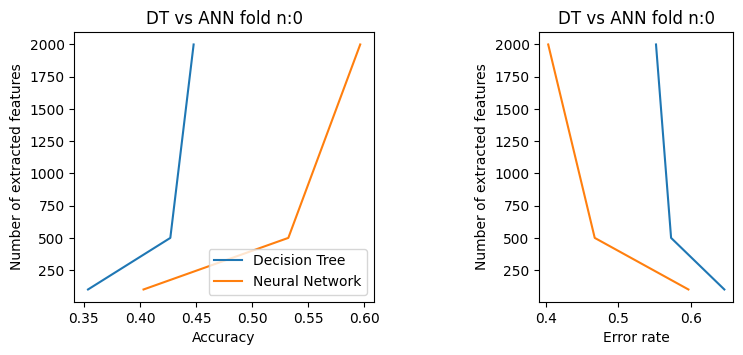


[+] number of fold used for the training set : 4 , number of fold used for the validation set 1

[+] Feature Set : {'fart', 'bt', '231', 'qa', 'maclik', '364406', 'echl', 'ovul', 'springer', 'tuft', 'mcnamara', 'besieg', 'hitachi', 'sen', 'ultran', 'muchli', 'audienc', '46', 'wrapper', 'resent', '8983', 'fill', 'c650', 'usr5binecho', 'dispdata', 'dogskin', 'personali', 'lowspe', 'bagwel', 'nauseum', 'achaemenid', 'scout', 'bufbufsiz1', 'pittsburgh', 'caf', 'syto', 'chapter', 'desktop', 'addict', 'beemer', '764', 'neal', 'doctrin', 'nonjewish', 'doshigh', 'tranni', 'typhoon', 'dso', 'weber', 'eve', '602', 'nidr', 'sabbath', 'gifconvert', 'quaker', 'gildea', 'crullerian', 'prototyp', 'father', '150', '600ohm', 'itd', 'nonind', '1063', 'structur', 'xclock', 'programmat', 'bornagain', 'maull', 'lydick', 'riihijarvi', 'caelli', 'hal9kannarbormiu', 'rusti', '6042221047', 'jtchernocfberkeleyedu', 'yah', 'randal', 'scaveng', 'asynch', 'chat', 'vmode', 'gallivan', 'fx', 'scale', 'denounc', 'ne

<ipython-input-4-3ba26732cd07>:137: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.savefig("fold_n"+str(index)+".png")
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.canvas.print_figure(bytes_io, **kw)


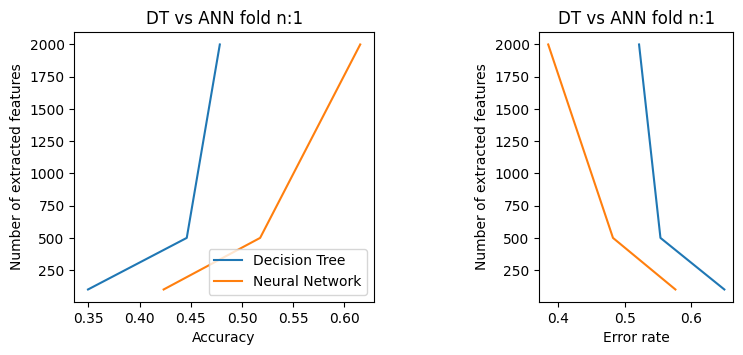


[+] number of fold used for the training set : 4 , number of fold used for the validation set 1

[+] Feature Set : {'fart', 'bt', '231', 'qa', 'afula', 'maclik', '364406', 'echl', 'springer', 'ovul', 'tuft', 'mcnamara', 'besieg', 'hitachi', 'sen', 'muchli', 'audienc', 'salem', '46', 'wrapper', 'resent', '12116', '8983', 'fill', 'c650', 'dispdata', 'dogskin', 'personali', 'lowspe', 'nauseum', 'achaemenid', 'scout', 'bufbufsiz1', 'pittsburgh', 'caf', 'chapter', 'desktop', 'addict', 'cbr900rr', 'beemer', 'neal', 'swyattbrahmsudeledu', 'doctrin', 'nonjewish', 'tranni', 'typhoon', 'dso', 'weber', 'eve', '602', 'sabbath', 'gifconvert', 'quaker', 'gildea', 'crullerian', 'polio', 'prototyp', 'spd', 'father', '150', 'itd', 'nonind', '1063', 'structur', 'xclock', 'programmat', 'maull', 'lydick', 'riihijarvi', 'hal9kannarbormiu', '1648', 'rusti', 'upstand', '6042221047', 'belaru', 'jtchernocfberkeleyedu', 'yah', 'randal', 'scaveng', 'asynch', 'waaaay', 'chat', 'vmode', 'gallivan', 'fx', 'highsec

<ipython-input-4-3ba26732cd07>:137: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.savefig("fold_n"+str(index)+".png")
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.canvas.print_figure(bytes_io, **kw)


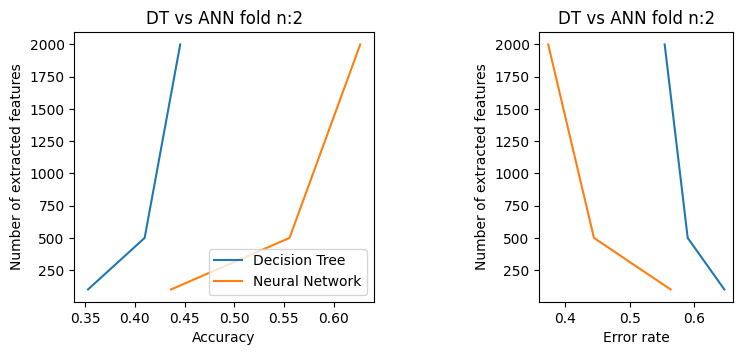


[+] number of fold used for the training set : 4 , number of fold used for the validation set 1

[+] Feature Set : {'fart', 'bt', '231', 'qa', 'maclik', 'valt', '364406', 'echl', 'springer', 'tuft', 'ovul', 'mcnamara', 'besieg', 'sen', 'audienc', 'salem', '46', 'wrapper', 'resent', '8983', 'fill', 'c650', 'usr5binecho', 'dogskin', 'personali', 'lowspe', 'bagwel', 'nauseum', 'returnpath', 'scout', 'bufbufsiz1', 'pittsburgh', 'caf', 'syto', 'chapter', 'desktop', 'addict', 'cbr900rr', 'beemer', '764', 'neal', 'doctrin', 'nonjewish', 'tranni', 'unswervingli', 'weber', 'eve', '602', 'nidr', 'sabbath', 'quaker', 'crullerian', 'polio', 'prototyp', 'spd', 'father', '150', '600ohm', 'itd', 'nonind', 'structur', 'xclock', 'programmat', 'bornagain', 'maull', 'lydick', 'riihijarvi', 'caelli', 'hal9kannarbormiu', 'rusti', 'belaru', 'jtchernocfberkeleyedu', 'yah', 'randal', 'scaveng', 'asynch', 'chat', 'vmode', 'fx', 'scale', 'denounc', 'nec', 'suv', 'gizmo', 'hurt', 'heinz', 'shall', 'sweater', 'w

<ipython-input-4-3ba26732cd07>:137: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.savefig("fold_n"+str(index)+".png")
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.canvas.print_figure(bytes_io, **kw)


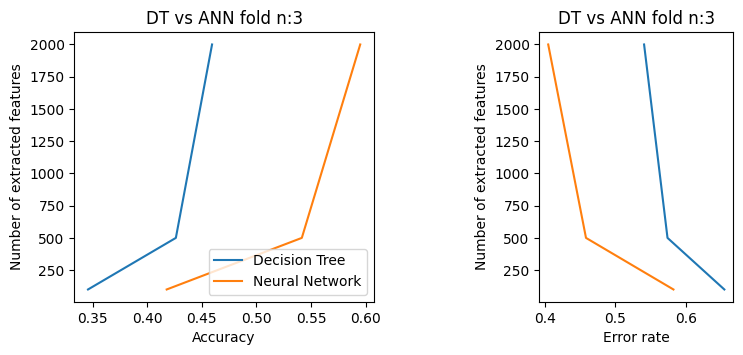


[+] number of fold used for the training set : 4 , number of fold used for the validation set 1

[+] Feature Set : {'bt', '231', 'qa', 'afula', 'echl', 'springer', 'ovul', 'tuft', 'mcnamara', 'besieg', 'hitachi', 'sen', 'muchli', 'phalanx', 'audienc', 'salem', '46', 'wrapper', 'resent', '8983', 'fill', 'c650', 'usr5binecho', 'dispdata', 'personali', 'achaemenid', 'scout', 'bufbufsiz1', 'pittsburgh', 'stirrup', 'syto', 'chapter', 'desktop', 'addict', 'cbr900rr', 'beemer', 'sprit', 'neal', 'doctrin', 'tranni', 'typhoon', 'weber', 'eve', '602', 'nidr', 'sabbath', 'gifconvert', 'quaker', 'gildea', 'polio', 'prototyp', 'spd', 'father', '150', '600ohm', 'itd', 'nonind', '1063', '80th', 'structur', 'xclock', 'programmat', 'bornagain', 'maull', 'lydick', 'riihijarvi', 'caelli', 'hal9kannarbormiu', 'rusti', '6042221047', 'jtchernocfberkeleyedu', 'q900', 'yah', 'randal', 'chat', 'vmode', 'gallivan', 'fx', 'scale', 'denounc', 'nec', 'suv', 'gizmo', 'hurt', 'heinz', 'remix', 'shall', '1853', 'wea

<ipython-input-4-3ba26732cd07>:137: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.savefig("fold_n"+str(index)+".png")
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.canvas.print_figure(bytes_io, **kw)


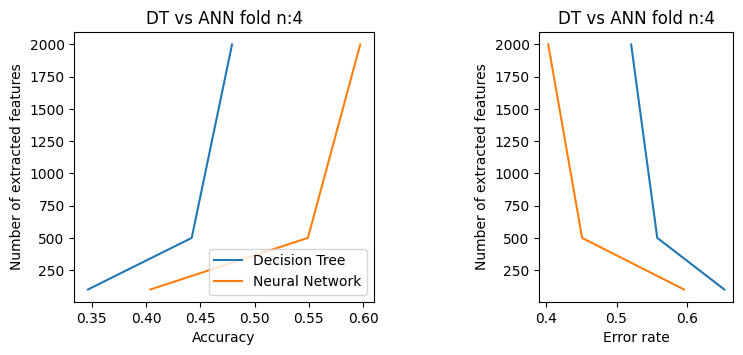

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB



def join_in_set(messages: list) -> set:
    """Join the lists inside messages into a single set,
    compose by the first 20000 word with more occurence among all the samples"""
    training_set = dict()
    for fold in messages:
      for el in fold:
          if el in training_set.keys():
            training_set[el] +=1
          else:
             training_set[el] =1
    return set(dict(sorted(training_set.items(), key=lambda item: item[1], reverse=True)[:20000]))

def compute_feature_vector(feature_dict: dict, messages_list: list, feature_matrix: np.ndarray) -> np.ndarray:
    """compute the feature_vector for a given features and the relative feature_matrix
      we count the occurence of each fearure if is present in the sample"""
    m_copy = feature_matrix.copy()
    for i, message in enumerate(messages_list):
        for word in message:
            if word in feature_dict:
                m_copy[i, feature_dict[word]] += 1
    return m_copy

def get_n_words_feature(words: list, feature_matrix: np.ndarray, messages: list, n_words: int) -> list:
    """Get the n_words with the highest mutual information."""
    res = dict(zip(words, mutual_info_classif(feature_matrix, messages, discrete_features=True)))
    res = dict(sorted(res.items(), key=lambda item: item[1], reverse=True)[:n_words])
    return res


# Cross-validation for 5 fold 
for index in range(len(training_folds_el)):

  # ITEMS 3.1, 3.2, 3.3

  # retrive the validation fold, 1 out of 5 k-fold 
  val_fold_el = training_folds_el.pop(0)
  val_fold_lbl = training_folds_labels.pop(0)
  print(f"\n[+] number of fold used for the training set : {len(training_folds_el)} , number of fold used for the validation set 1")

  # join all the training samples in a list based on 4 folds 
  tr_fold = []
  for tr in  training_folds_el : tr_fold.extend(tr)

  # join all the training labels in a list based on 4 folds 
  tr_labels = []
  for tr_lbl in  training_folds_labels : tr_labels.extend(tr_lbl)

  # retrinving the feature_set of our training set 
  feature_set = join_in_set(tr_fold)
  print(f"\n[+] Feature Set : {feature_set}")  
  print(f"\n    Number of Features : {len(feature_set)} -> fold N°{index}")  
  # transform training_set into a dictionary with value corresponding to the index of the word
  feature_dict = dict(zip(feature_set, range(len(feature_set))))

  # create the empty features-matrix for training and validation set:
  # - rows: represent the samples  
  # - cols: represent the features
  training_matrix = np.zeros((len(tr_fold), len(feature_dict)), dtype=float)
  validation_matrix = np.zeros((len(val_fold_el), len(feature_dict)), dtype=float)

  # count the number of occurences of each feature for each sample in the training set and validation set 
  training_matrix = compute_feature_vector(feature_dict, tr_fold, training_matrix)
  validation_matrix = compute_feature_vector(feature_dict, val_fold_el, validation_matrix)
  
  # Setting the diffent k values of features 
  k = [100,500,2000]

  # retriving the 2000 beast feature (with higer information gain)
  features = get_n_words_feature(feature_dict.values(), training_matrix, tr_labels, k[2])
  print(f"\n[+] features dictionary (index in the matrix word,Information gain) {features}")
  features = list(features.keys())
  
  # instantiate the Decision Tree
  classifier_tree = tree.DecisionTreeClassifier()

  # the accuracy and error rate lists used to store the differnets metrics among the different values of k 
  accuracy_DT = []
  error_rate_DT = []

  #train the DT with the training set and classify the validation set for different values of k 
  for el in k:
    classifier_tree = classifier_tree.fit(training_matrix[:,features[0:el]], tr_labels)
    y_pred_DT = classifier_tree.predict(validation_matrix[:,features[0:el]])
    accuracy_DT.append(metrics.accuracy_score(val_fold_lbl, y_pred_DT))
    error_rate_DT.append(1-accuracy_DT[-1])
  
  print(f"\n[+] accuracy of the Decision tree for 100 , 500 and 2000 features are respectevly : {accuracy_DT}")
  
  # istantiate the plot and ploting the result of DT 
  plt.rcParams["figure.figsize"] = [8.50, 3.50]
  plt.rcParams["figure.autolayout"] = True
  plt.subplot(1, 3, 3)
  plt.plot(error_rate_DT,k, label = "Decision Tree")
  plt.title("DT vs ANN fold n:" + str(index))
  plt.xlabel("Error rate")
  plt.ylabel("Number of extracted features")
  plt.subplot(1, 2, 1)
  plt.plot(accuracy_DT, k , label = "Decision Tree")
  plt.title("DT vs ANN fold n:" + str(index))
  plt.xlabel("Accuracy")
  plt.ylabel("Number of extracted features")
  
  
  # Istantiate the Neural network classifier
  mlp = MLPClassifier(hidden_layer_sizes=(50,),activation='relu', solver='sgd', learning_rate = 'adaptive',  max_iter=500, early_stopping=True)

  # the accuracy and error rate lists used to store the differnets metrics among the different values of k 
  accuracy_NN = []
  error_rate_NN = []

  #train the NN with the training set and classify the validation set for different values of k 
  for el in k:
    mlp.fit(training_matrix[:,features[0:el]],tr_labels)  
    y_pred_NN = mlp.predict(validation_matrix[:,features[0:el]])
    accuracy_NN.append(metrics.accuracy_score(val_fold_lbl, y_pred_NN))
    error_rate_NN.append(1-accuracy_NN[-1])

  print(f"\n[+] accuracy of the Neural network for 100 , 500 and 2000 features are respectevly : {accuracy_NN}")

  # ploting the result of NN 
  plt.subplot(1, 2, 1)
  plt.plot(accuracy_NN,k, label = "Neural Network")
  plt.legend()
  plt.subplot(1, 3, 3)
  plt.plot(error_rate_NN,k, label = "Neural Network")

  # save the plot for each iteration of the cross validation  
  plt.savefig("fold_n"+str(index)+".png")
  plt.show()

  #putting the used validation fold at the end of the queue 
  training_folds_el.append(val_fold_el)
  training_folds_labels.append(val_fold_lbl)

# **Test the classifiers**

According to the results obtained in the previous steps, we train a Neural Network over the whole training set, using 2000 features.
After the training, we evaluate the accuracy and the error rate using the test set given in the library. This test set provided by ```sklearn``` is not randomly chosen but follows some criteria to improve the generalization capability

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
import numpy as np


def join_in_set(messages: list) -> set:
    """Join the lists inside messages into a single set."""
    training_set = dict()
    for fold in messages:
      for el in fold:
          if el in training_set.keys():
            training_set[el] +=1
          else:
             training_set[el] =1
    return set(dict(sorted(training_set.items(), key=lambda item: item[1], reverse=True)[:20000]))

def compute_feature_vector(feature_dict: dict, messages_list: list, feature_matrix: np.ndarray) -> np.ndarray:
    """compute the feature_vector for a given features and the relative feature_matrix
      we count the occurence of each fearure if is present in the sample"""
    m_copy = feature_matrix.copy()
    for i, message in enumerate(messages_list):
        for word in message:
            if word in feature_dict:
                #we increase the counter
                m_copy[i, feature_dict[word]] += 1
    return m_copy


def get_n_words_feature(words: list, feature_matrix: np.ndarray, messages: list, n_words: int) -> list:
    """Get the n_words with the highest mutual information."""
    res = dict(zip(words, mutual_info_classif(feature_matrix, messages, discrete_features=True)))
    res = dict(sorted(res.items(), key=lambda item: item[1], reverse=True)[:n_words])
    return res

#extract the feature from all the training set 
feature_set = join_in_set(train["msg"])
print(f"[+] Feature Set : {feature_set}")

# transform training_set into a dictionary with value corresponding to the index of the word
feature_dict = dict(zip(feature_set, range(len(feature_set))))
print(f"\n[+] Number of different Words : {len(feature_dict)}")

#create a empty feature matrix for the training and the test set  
training_matrix = np.zeros((len(train["msg"]), len(feature_dict)), dtype=int)
training_matrix_test = np.zeros((len(test["msg"]), len(feature_dict)), dtype=int)

# compute the feature matrix where for each sample we count the number of occurence of the words in the sample 
training_matrix = compute_feature_vector(feature_dict, train["msg"], training_matrix)
training_matrix_test = compute_feature_vector(feature_dict, test["msg"], training_matrix_test)

res = get_n_words_feature(feature_dict.values(), training_matrix, train['lbl'], 2000)
print(f"\n[+] Features Dictionary (index in the matrix word,Information gain) {res}")
res = list(res.keys())

#reshaping the training and the test matrix selecting the columns that represent the most significative features
training_matrix = training_matrix[:,res]
training_matrix_test = training_matrix_test[:,res]

[+] Feature Set : {'nonprocr', 'cloud', 'seventhday', 'avoid', 'propag', 'purchas', 'coher', 'dice', 'mindbrain', 'diehard', '31', 'fritter', 'meet', 'nom', 'brain', 'psalmist', 'flavour', 'snailmail', 'book', 'curs', 'birthpang', 'falibl', '278', 'photo', 'build', 'doc', 'communion', 'twist', 'entitl', 'blais', 'blew', 'psalm', 'cosmicli', 'zazenaustinibmcom', 'vera', 'toma', 'strengthen', 'doolittl', 'gave', 'brimston', 'talkorigin', 'nostalgia', 'millennia', 'defyinganytheisttorepli', 'adversari', 'vengeanc', 'physic', 'outrag', 'jot', '2127', 'spi', 'pdo', 'istelf', 'sabbath', 'omnipot', 'termonolog', 'rough', 'thanksgiv', 'orgin', 'encroach', 'protest', 'theme', 'mileag', 'eleph', 'tyndal', 'nietzch', 'rsv', 'champaignurbana', 'obsen', 'revel', '212225', 'guarante', 'carefullywritten', 'appreci', 'sophomor', 'interdepend', 'calus', 'determin', '4084283553', 'anyhow', 'jewish', 'primer', 'version', 'casualti', 'breed', 'whip', 'gmt', 'couldv', 'interdisciplinari', 'enoch', '19go', 

## Test with all categories
From the results above, the best choice is a Neural Network with 2000 features

In [ ]:
#istantiate the neural network 
mlp = MLPClassifier(hidden_layer_sizes=(50,),activation='relu', solver='sgd', learning_rate = 'adaptive',  max_iter=500, early_stopping=True)

#train the classifier and try to predict the label of the test set
mlp.fit(training_matrix,train['lbl'])  
y_pred_NN = mlp.predict(training_matrix_test)

#compute the acuracy and the error rate 
accuracy_NN = (metrics.accuracy_score(test["lbl"], y_pred_NN))
error_rate_NN = 1-accuracy_NN

print(f"\n[+] Metrics of the Neural Network :")
print(f"    Accuracy - {accuracy_NN}")
print(f"    Error Rate - {error_rate_NN}")


[+] Metrics of the Neural Network :
    Accuracy - 0.698744769874477
    Error Rate - 0.301255230125523


## Test with two categories
From the results above, the best choice is a Decision Tree with 2000 features

In [ ]:
#istantiate the Decision Tree
classifier_tree = tree.DecisionTreeClassifier()

#train the classifier and try to predict the label of the test set
classifier_tree.fit(training_matrix,train['lbl'])  
y_pred_DT = mlp.predict(training_matrix_test)

#compute the acuracy and the error rate 
accuracy_DT = (metrics.accuracy_score(test["lbl"], y_pred_DT))
error_rate_DT = 1-accuracy_DT

print(f"\n[+] Metrics of the Decision Tree:")
print(f"    Accuracy - {accuracy_DT}")
print(f"    Error Rate - {error_rate_DT}")


[+] Metrics of the Decision Tree:
    Accuracy - 0.698744769874477
    Error Rate - 0.301255230125523


# **Conclusion**

To sum up, we will discuss the results obtained in different scenarios we tried.

## Comparison with all categories
Using 2000 features and the Neural Network we reach an accuracy of around 56%.
If we consider that our dataset is made by single-labelled samples over 20 possible different labels, trying to guess the label of a message, the probability is 5%, given by the classical (a priori) probability formula:

![classical_probability](https://drive.google.com/uc?id=1l0ynOWZ2yoBcQ0OHZGOXT34rUDmaBuge)

Where the favourable outcomes are equal to one (because our samples are single-labelled) and the total number of outcomes is 20.


## Comparison with only two categories
Using 2000 features and the Decision Tree we reach an accuracy of around 70%.
If we consider that our dataset is made of single-labelled samples over 2 possible different labels, trying to guess the label of a message, the probability is 50%.

Where the favourable outcomes are equal to one (because our samples are single-labelled) and the total number of outcomes is 2.



## Possible improvements

Possible improvements to this project can be:
- **Increase the number of features**: observing the plots above it is clear that it is possible to reach a better accuracy by increasing the number of features over 2000. Increasing the number of features will require a longer execution time.
- **Choose a better feature extraction method**: we used the occurrences method, which counts the occurrences of a feature in the samples, but of course, there exist other techniques which perform better over datasets like that. For instance, the frequency method evaluates the frequency of the feature in the samples, giving a better representation of the weight of each feature.
- **Choose a better classifier**: by project request we use a Decision Tree and a Neural Network but exist classifiers which have better behaviour in text classification, for instance, the Naive-Bayes Classifier.
We tested this classifier in the snippet below.


Combining all these improvements we reached an accuracy of 82%.






In [ ]:
from matplotlib import pprint
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics 
from sklearn.neural_network import MLPClassifier 
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# retriving the train  and the test set 
news_groups_train = fetch_20newsgroups(subset='train', shuffle=True, download_if_missing=False)
news_groups_test = fetch_20newsgroups(subset='test', shuffle=True, download_if_missing=False)

# Creating our TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.97, min_df=2,max_features=None,stop_words='english')

# retriving the sample and the labels of our training and test set 
x_train, y_train = news_groups_train.data, news_groups_train.target
x_test, y_test = news_groups_test.data, news_groups_test.target

# calucalte the features vector of training and test set using the fetures calculated in training set
tfidf_x_sp_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_x_test = tfidf_vectorizer.transform(x_test)

# istantiate our classifier 
mlp = MultinomialNB(alpha=0.5)

# fitting the model with our training set 
mlp.fit(tfidf_x_sp_train, y_train)

# tri to predict the label in the test set 
y_pred = mlp.predict(tfidf_x_test)

print(f"[+] accuracy using all the features and using the Bayesian Classifier : {metrics.accuracy_score(y_test,y_pred)} ")
print(f"    error rate :  {1-metrics.accuracy_score(y_test,y_pred)} ")

[+] accuracy using all the features and using the Bayesian Classifier : 0.8281996813595327 
    error rate :  0.1718003186404673 
